In [48]:
from clearml import Task

dataset = 'German'
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
tags = [dataset]
task_list = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter,  # Optional[Dict]
    tags=tags
)





In [49]:
MAX_GRAD_NORMS = [1, 0.01]
EPSILONS = [11.5, 3.2, 0.96, 0.72]
components = ['autoencoder', 'adversary', 'classifier']

In [100]:
import matplotlib.pyplot as plt
import numpy as np
best_epochs = {}
acc = {}
dp = {}
eod = {}
eop = {}
for MAX_GRAD_NORM in MAX_GRAD_NORMS:
    best_epoch_comp = {}
    acc_comp = {}
    dp_comp = {}
    eop_comp = {}
    eod_comp = {}
    for component in components:
        best_epoch_eps = {}
        acc_list = {}
        dp_list = {}
        eop_list = {}
        eod_list = {}
        for EPSILON in EPSILONS:
            l = [i.get_reported_scalars() for i in task_list if
                 'grad_norm='+str(MAX_GRAD_NORM) in i.data.tags and
                 component in i.data.tags and
                 "ε="+str(EPSILON) in i.data.tags]
            adv = [i['Adversary Loss']['test loss']['y'] for i in l]
            adv_mean = np.array(adv[0])
            
            cl = [i['Classifier Loss']['test loss']['y'] for i in l]
            cl_mean = np.array(cl[0])
            
            
            for i in range(1, len(adv)):
                adv_mean += np.array(adv[i])
                cl_mean += np.array(cl[i])
            adv_mean = np.array(adv_mean)
            cl_mean = np.array(cl_mean)
            adv_mean /= len(adv)
            cl_mean /= len(cl)
            

            w = int(len(adv_mean)*0.5)
            sm_y_adv = []
            sm_y_cl = []
            for i in range(len(adv_mean) - w):
                value = np.mean(adv_mean[i:i+w])
                sm_y_adv.append(value)
                value = np.mean(cl_mean[i:i+w])
                sm_y_cl.append(value)
            adv_epoch = np.argmax(sm_y_adv)
            cl_epoch = np.argmin(sm_y_cl)
            epoch_ = min(adv_epoch, cl_epoch)
            epoch_ = max(epoch_, 50)
            print('MAX_GRAD_NORM:', MAX_GRAD_NORM, 'component:', component, 'eps:', EPSILON, 'best epoch:', epoch_)
            acc_, acc_unfair = [i['Accuracy']['LFR']['y'][epoch_] for i in l], [i['Accuracy']['Unfair']['y'][epoch_] for i in l]
            dp_, dp_unfair = [i['ΔDP']['LFR']['y'][epoch_] for i in l], [i['ΔDP']['Unfair']['y'][epoch_] for i in l] 
            eod_, eod_unfair = [i['ΔEOD']['LFR']['y'][epoch_] for i in l], [i['ΔEOD']['Unfair']['y'][epoch_] for i in l] 
            eop_, eop_unfair = [i['ΔEOP']['LFR']['y'][epoch_] for i in l], [i['ΔEOP']['Unfair']['y'][epoch_] for i in l]
            
            acc_list[EPSILON] = (np.mean(acc_), np.std(acc_, ddof=1), np.mean(acc_unfair))
            dp_list[EPSILON] = (np.mean(dp_), np.std(dp_, ddof=1), np.mean(dp_unfair))
            eod_list[EPSILON] = (np.mean(eod_), np.std(eod_, ddof=1), np.mean(eod_unfair))
            eop_list[EPSILON] = (np.mean(eop_), np.std(eop_, ddof=1), np.mean(eop_unfair))
            
            best_epoch_eps[EPSILON] = epoch_
            
        acc_comp[component] = acc_list
        dp_comp[component] = dp_list
        eod_comp[component] = eod_list
        eop_comp[component] = eop_list
        
        best_epoch_comp[component] = best_epoch_eps
        
    acc[MAX_GRAD_NORM] = acc_comp
    dp[MAX_GRAD_NORM] = dp_comp
    eop[MAX_GRAD_NORM] = eop_comp
    eod[MAX_GRAD_NORM] = eod_comp
    best_epochs[MAX_GRAD_NORM] = best_epoch_comp


MAX_GRAD_NORM: 1 component: autoencoder eps: 11.5 best epoch: 193
MAX_GRAD_NORM: 1 component: autoencoder eps: 3.2 best epoch: 249
MAX_GRAD_NORM: 1 component: autoencoder eps: 0.96 best epoch: 249
MAX_GRAD_NORM: 1 component: autoencoder eps: 0.72 best epoch: 249
MAX_GRAD_NORM: 1 component: adversary eps: 11.5 best epoch: 215
MAX_GRAD_NORM: 1 component: adversary eps: 3.2 best epoch: 195
MAX_GRAD_NORM: 1 component: adversary eps: 0.96 best epoch: 195
MAX_GRAD_NORM: 1 component: adversary eps: 0.72 best epoch: 117
MAX_GRAD_NORM: 1 component: classifier eps: 11.5 best epoch: 50
MAX_GRAD_NORM: 1 component: classifier eps: 3.2 best epoch: 67
MAX_GRAD_NORM: 1 component: classifier eps: 0.96 best epoch: 97
MAX_GRAD_NORM: 1 component: classifier eps: 0.72 best epoch: 123
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 11.5 best epoch: 249
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 3.2 best epoch: 249
MAX_GRAD_NORM: 0.01 component: autoencoder eps: 0.96 best epoch: 249
MAX_GRAD_NORM: 0.01 

"\nprint(task_list[0].get_reported_scalars()['Adversary Loss']['test loss']['name'])\nprint(task_list[0].get_parameters_as_dict())\ntest_x = task_list[0].get_reported_scalars()['Adversary Loss']['test loss']['x']\n#test_y = task_list[0].get_reported_scalars()['Adversary Loss']['test loss']['y']\n\nw = int(len(test_y)*0.25)\nsm_y = []\nfor i in range(len(test_y) - w):\n    value = np.mean(test_y[i:i+w])\n    sm_y.append(value)\n\nplt.plot(test_x[:len(test_x)-w], sm_y)"

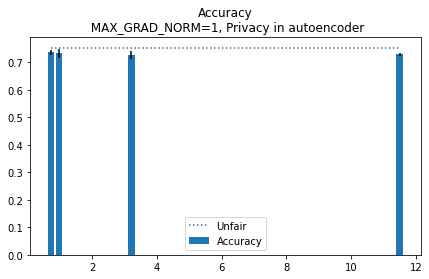

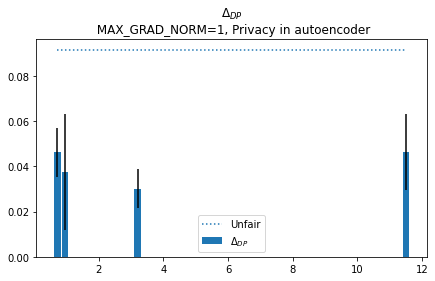

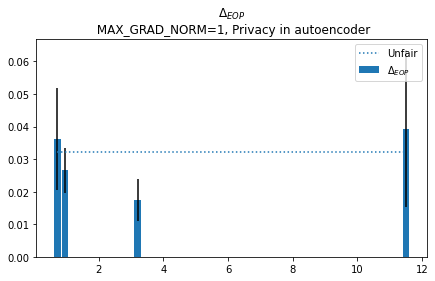

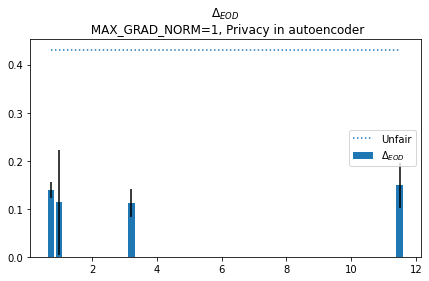

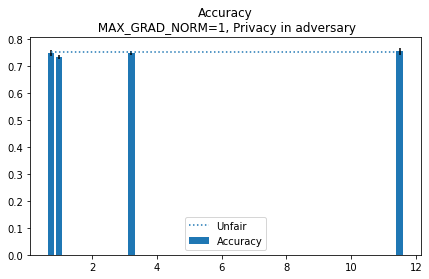

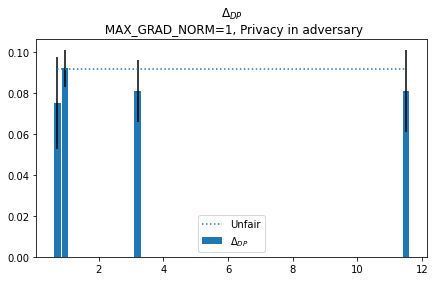

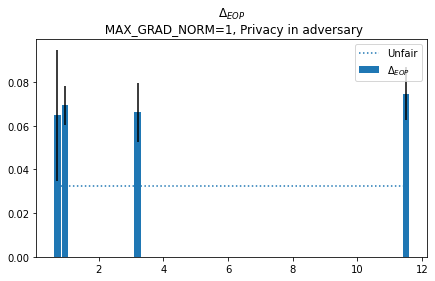

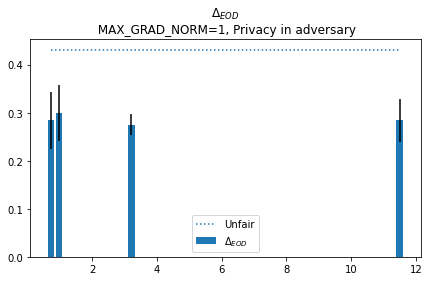

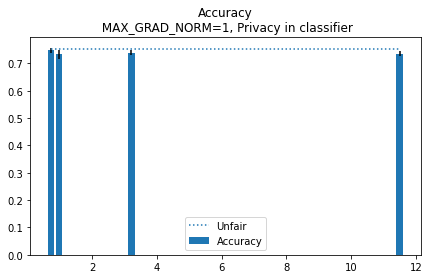

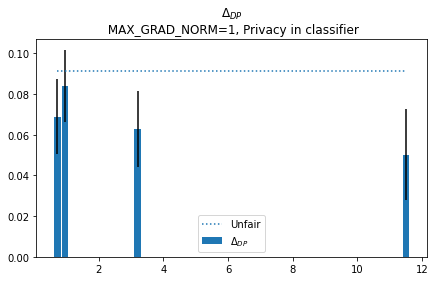

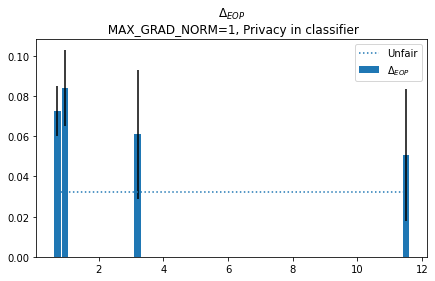

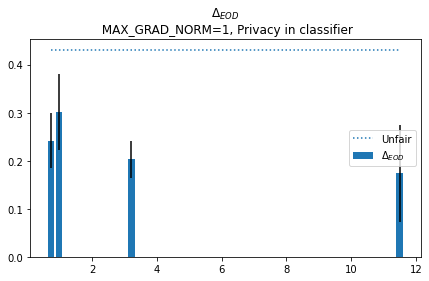

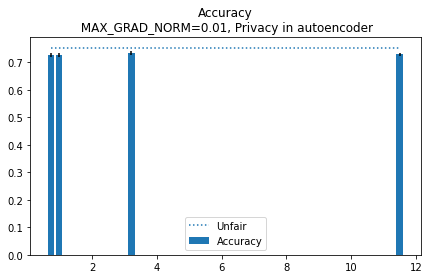

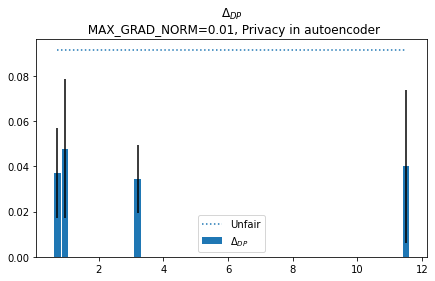

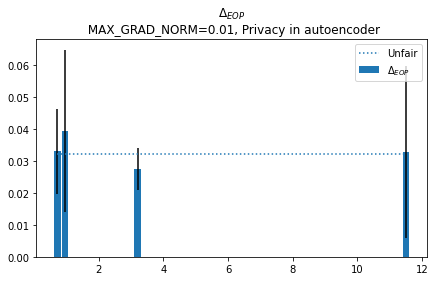

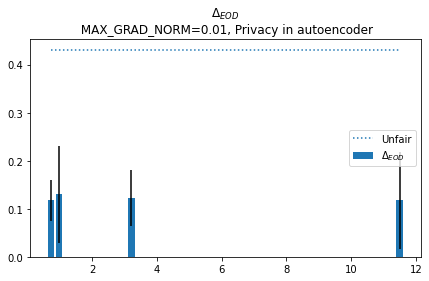

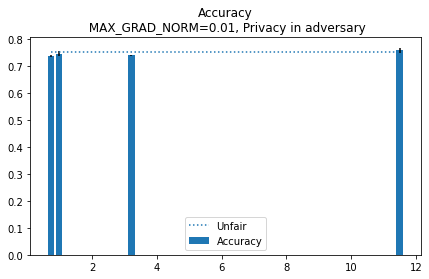

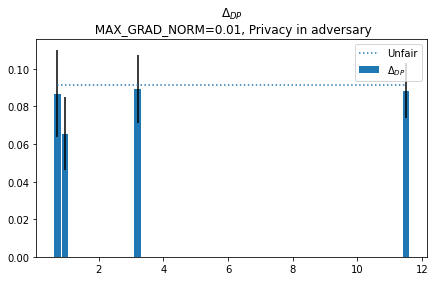

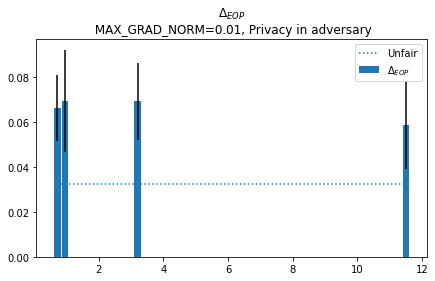

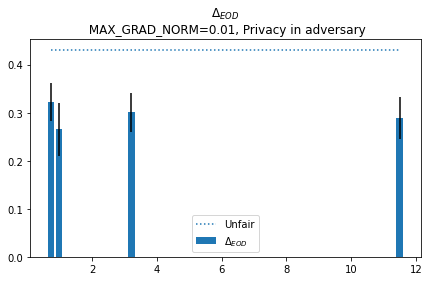

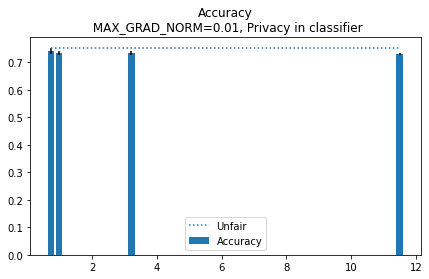

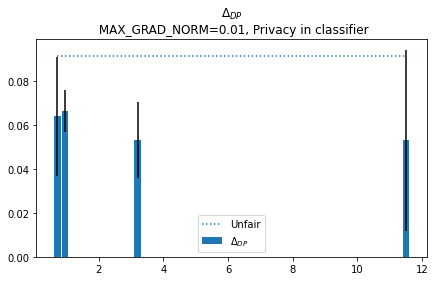

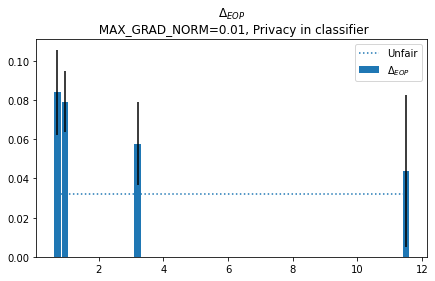

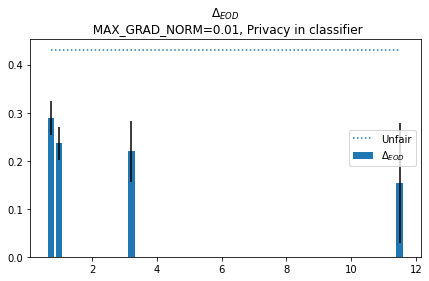

In [109]:
import matplotlib
%matplotlib inline
for MAX_GRAD_NORM in MAX_GRAD_NORMS:
    for component in components:
        labels = ["Accuracy", "$\Delta_{DP}$", '$\Delta_{EOP}$', '$\Delta_{EOD}$']
        y = [
            [acc[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS)],
            [dp[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS)],
            [eop[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS)],
            [eod[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS)]
        ]
        std = [
            [acc[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS)],
            [dp[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS)],
            [eop[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS)],
            [eod[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS)]
        ]
        unfair = [
            [acc[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS)],
            [dp[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS)],
            [eop[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS)],
            [eod[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS)]
        ]
        for p in range(len(y)):
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
            ax.bar(sorted(EPSILONS), y[p], 0.2, yerr=std[p], label=labels[p])
            ax.set_title(labels[p] + "\n MAX_GRAD_NORM=" + str(MAX_GRAD_NORM) + ", Privacy in " + component)
            ax.plot(sorted(EPSILONS), unfair[p], label="Unfair", linestyle='dotted')
            ax.legend()
            plt.show()
            

            
            